In [16]:
from statsmodels.tsa.arima_model import ARIMA
from preprocessing import *
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

finalData = getting_final_data('aapl')

df_arima = finalData['Close']

print (df_arima.head(5))

model = ARIMA(df_arima, order=(5,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# residuals = pd.DataFrame(model_fit.resid)
# residuals.plot()
# plt.show()
# residuals.plot(kind='kde')
# plt.show()
# print(residuals.describe())

# X = df_arima.values
# size = int(len(X) * 0.85)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# for t in range(len(test)):
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit(disp=0)
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = test[t]
#     history.append(obs)
#     #print('predicted=%f, expected=%f' % (yhat, obs))
# error = mean_squared_error(test, predictions)
# print('Test MSE: %.3f' % error)
# # plot
# plt.plot(test, color='blue')
# plt.plot(predictions, color='red')
# plt.show()


2010-01-04    30.572857
2010-01-05    30.625713
2010-01-06    30.138571
2010-01-07    30.082857
2010-01-08    30.282858
Freq: D, Name: Close, dtype: float64
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2890
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -4264.886
Method:                       css-mle   S.D. of innovations              1.058
Date:                Sun, 03 Dec 2017   AIC                           8545.773
Time:                        14:58:20   BIC                           8593.525
Sample:                    01-05-2010   HQIC                          8562.982
                         - 12-03-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0486      0.021      2.316 

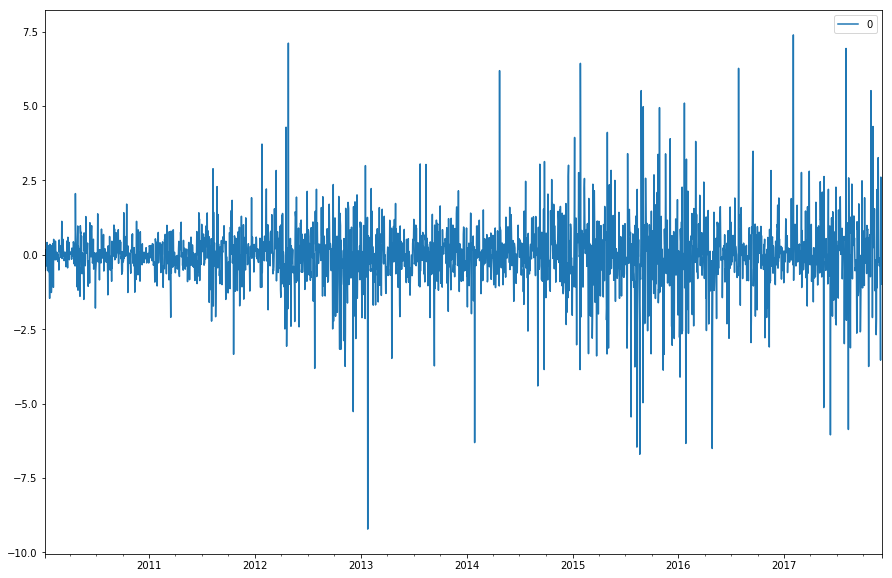

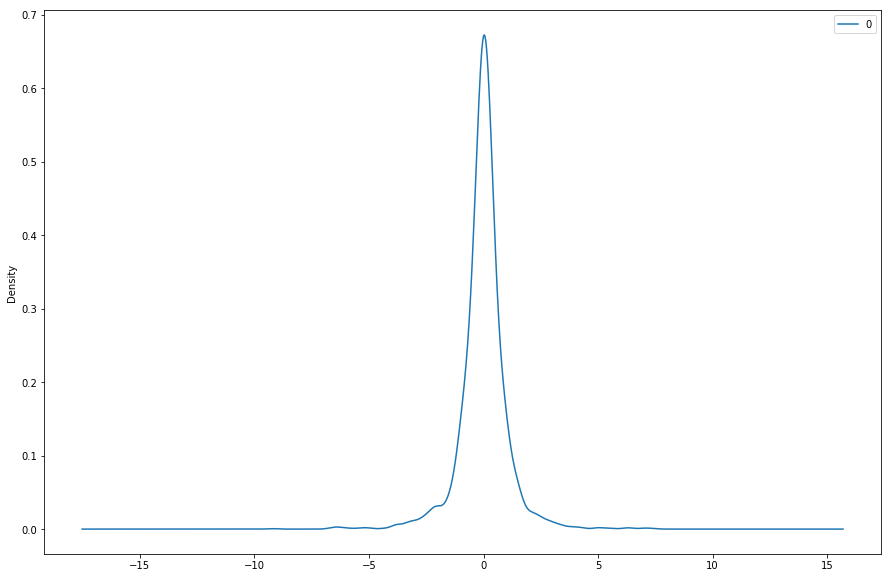

                 0
count  2890.000000
mean     -0.000004
std       1.058624
min      -9.218620
25%      -0.366180
50%       0.020394
75%       0.394491
max       7.387221


In [17]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())


Test MSE: 1.770


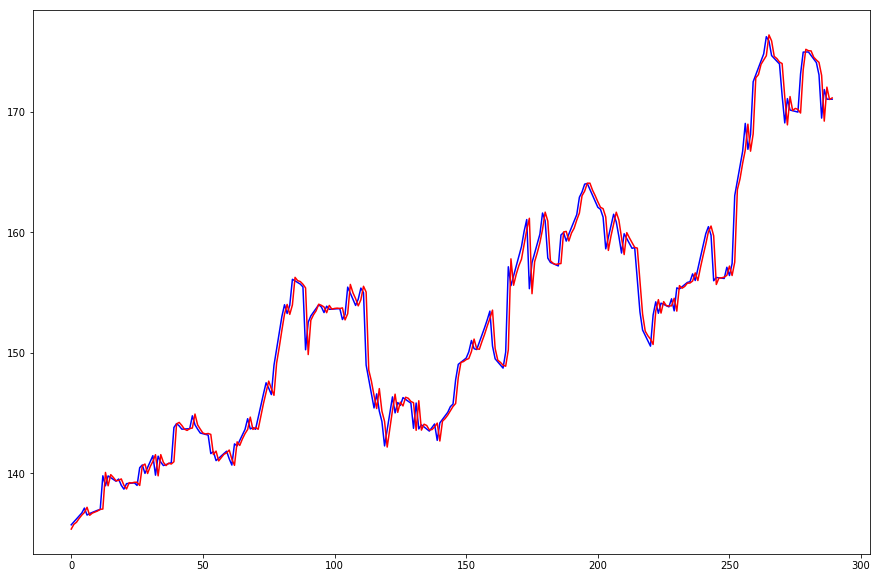

In [28]:
from sklearn.metrics import mean_squared_error

X = df_arima.values
size = int(len(X) * 0.90)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test, color='blue')
plt.plot(predictions, color='red')
plt.savefig("images/arima.png")
plt.show()

In [70]:
df_arima = finalData['Close']
df_arima.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-09', '2010-01-10', '2010-01-11',
               '2010-01-12', '2010-01-13',
               ...
               '2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18'],
              dtype='datetime64[ns]', length=2876, freq='D')

In [71]:
model = ARIMA(df_arima, order=(5,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2875
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -4234.806
Method:                       css-mle   S.D. of innovations              1.056
Date:                Sat, 18 Nov 2017   AIC                           8485.612
Time:                        19:07:59   BIC                           8533.322
Sample:                    01-05-2010   HQIC                          8502.810
                         - 11-18-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0486      0.021      2.316      0.021       0.007       0.090
ar.L1.D.Close    -0.1764      0.210     -0.840      0.401      -0.588       0.235
ar.L2.D.Close     0.0312      0.025     

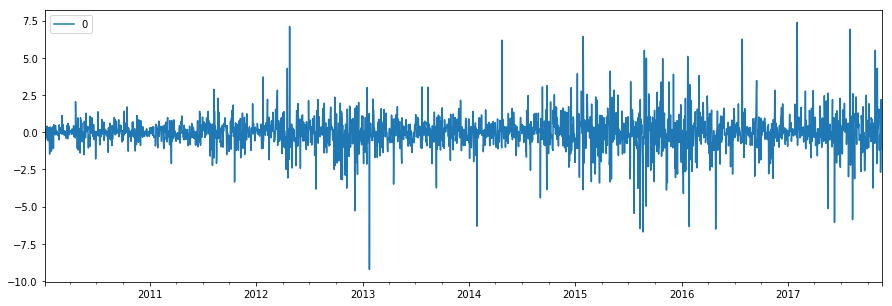

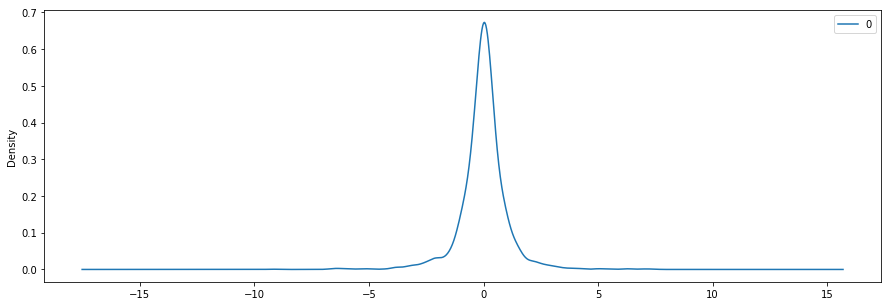

                 0
count  2875.000000
mean     -0.000004
std       1.055703
min      -9.219611
25%      -0.366320
50%       0.020891
75%       0.394649
max       7.387389


In [72]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Test MSE: 1.503


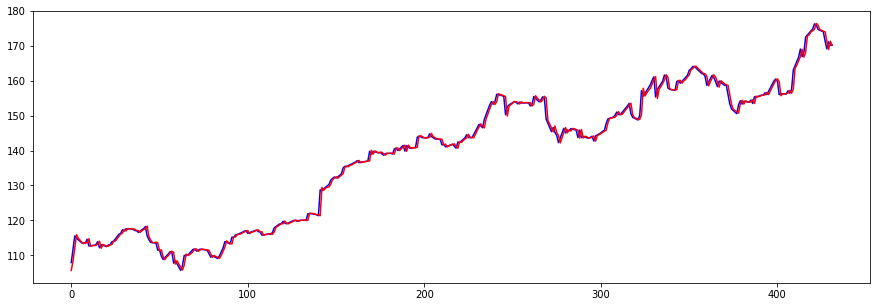

In [73]:
X = df_arima.values
size = int(len(X) * 0.85)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)): 
#     model = ARIMA(history, order=(5,1,0))
#     model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test, color='blue')
plt.plot(predictions, color='red')
plt.show()

In [45]:
# from sklearn import preprocessing

# finalDataNorm = preprocessing.normalize(finalData, norm='l2', axis=1)

In [46]:
# len(finalDataNorm[0])

14

In [47]:
# writeDF = pd.DataFrame(finalDataNorm)

In [49]:
# # writeDF.columns = ['open', 'high', 'low', 'close','adj close','volume','prev_diff','close_50_sma','10_day_volatility', \
#                    'sm_open','sm_high','sm_low','sm_close','sm_adj_close','sm_volume','sm_prev_diff','sm_close_50_sma',\
#                    'sm_10_day_volatility']

In [51]:
# writeDF.head(5)

In [52]:
# writeDF.to_csv('./aaplNorm.csv')

In [53]:
# finalData.to_csv('./aapl.csv')

In [54]:
# writeDF.insert(0, "date", finalData.index)

In [ ]:
# def applyTimeLag(dataset, lags, delta):
#     maxLag = max(lags)

#     columns = dataset.columns[::(2*max(delta)-1)]
#     for column in columns:
#         newcolumn = column + str(maxLag)
#         dataset[newcolumn] = dataset[column].shift(maxLag)

#     return dataset.iloc[maxLag:-1, :]


In [ ]:
# maxdelta = 30
# delta = range(8, maxdelta)

# high_value = 365
# high_value = min(high_value, writeDF.shape[0] - 1)

# writeDF = applyTimeLag(writeDF, [high_value], delta)

In [55]:
# writeDF.head(5)

In [ ]:
# import numpy as np

# index = int(np.floor(writeDF.shape[0]*0.95))
# train, test = writeDF[:index], writeDF[index:]
# print('Size of train set: ', train.shape)
# print('Size of test set: ', test.shape)

In [ ]:
# train.head(5)

In [ ]:
# X_train = train.loc[:, train.columns != 'close']
# X_train = X_train.loc[:, X_train.columns != 'date']
# X_train = X_train.loc[:, X_train.columns != 'date365']
# y_train = finalData['close'][:index]

In [ ]:
# X_train.head(5)

In [ ]:
# y_train.head(5)

In [ ]:
# X_test = test.loc[:, test.columns != 'close']
# X_test = X_test.loc[:, X_test.columns != 'date']
# X_test = X_test.loc[:, X_test.columns != 'date365']
# y_test = finalData['close'][index:]

In [ ]:
# y_test.shape

In [ ]:
# from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

# # regr = RandomForestRegressor(n_estimators=10)
# # regr.fit(X_train, y_train)

# regr = BaggingRegressor()
# regr.fit(X_train, y_train)

In [ ]:
# print(regr.feature_importances_)

In [ ]:
# print(regr.predict(X_test)[0:6])

In [ ]:
# y_test.head(5)

In [ ]:
# # x = writeDF[:,0:9]
# x = writeDF.iloc[:,0:16]
# x = x.set_index('date')

In [ ]:
# x.close = finalData.close

In [ ]:
# x = x.sort_index()
# x.head(5)

In [ ]:
# index = int(np.floor(x.shape[0]*0.90))
# train, test = x[:index], x[index:]
# print('Size of train set: ', train.shape)
# print('Size of test set: ', test.shape)

In [ ]:
# X_train = train.loc[:, train.columns != 'close']
# y_train = train['close']
# X_test = test.loc[:, test.columns != 'close']
# y_test = test['close']

In [ ]:
# X_train.head(5)

In [ ]:
# from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

# regr = RandomForestRegressor(n_estimators=10, random_state = 10)
# regr.fit(X_train, y_train)

# regr = BaggingRegressor()
# regr.fit(X_train, y_train)


In [ ]:
# predictions = regr.predict(X_test)

In [ ]:
# error = mean_squared_error(y_test, predictions)
# plt.plot(y_test, color='blue')
# # plt.plot(prediction, color='red')
# # plt.show()
# error

In [ ]:
# y_t = []
# for item in y_test:
#     y_t.append(item)

In [ ]:
# plt.plot(y_t, color='blue')
# plt.plot(predictions, color='red')
# plt.show()

In [ ]:
# predictions[0:9]

In [ ]:
# y_t[0:9]

In [74]:
y = finalData
y.head(5)

,Open,High,Low,Close,Adj Close,Volume,prev_diff,sm_open,sm_high,sm_low,sm_close,sm_adj_close,sm_volume,sm_prev_diff
2010-01-04,30.490000,30.642857,30.340000,30.572857,27.406532,123432400.0,0.000000,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09,0.000000
2010-01-05,30.657143,30.798571,30.464285,30.625713,27.453915,150476200.0,0.052856,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09,3.530030
2010-01-06,30.625713,30.747143,30.107143,30.138571,27.017223,138040000.0,-0.487142,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09,0.619995
2010-01-07,30.250000,30.285715,29.864286,30.082857,26.967278,119282800.0,-0.055714,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09,4.549926
2010-01-08,30.042856,30.285715,29.865715,30.282858,27.146566,111902700.0,0.200001,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09,3.290039


In [76]:
y["20d"] = np.round(y["Close"].rolling(window = 20, center = False).mean(), 2)
z = y['Close'][0:19]
y['20d'][0:19] = z

In [79]:
y.head(5)

,Open,High,Low,Close,Adj Close,Volume,prev_diff,sm_open,sm_high,sm_low,sm_close,sm_adj_close,sm_volume,sm_prev_diff,20d,50d
2010-01-04,30.490000,30.642857,30.340000,30.572857,27.406532,123432400.0,0.000000,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09,0.000000,30.572857,30.572857
2010-01-05,30.657143,30.798571,30.464285,30.625713,27.453915,150476200.0,0.052856,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09,3.530030,30.625713,30.625713
2010-01-06,30.625713,30.747143,30.107143,30.138571,27.017223,138040000.0,-0.487142,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09,0.619995,30.138571,30.138571
2010-01-07,30.250000,30.285715,29.864286,30.082857,26.967278,119282800.0,-0.055714,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09,4.549926,30.082857,30.082857
2010-01-08,30.042856,30.285715,29.865715,30.282858,27.146566,111902700.0,0.200001,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09,3.290039,30.282858,30.282858


In [78]:
# y["50d"] = np.round(y["Close"].rolling(window = 50, center = False).mean(), 2)
# z1 = y['Close'][0:49]
# y['50d'][0:49] = z1

In [30]:
# y["100d"] = np.round(y["Close"].rolling(window = 100, center = False).mean(), 2)
# z1 = y['Close'][0:99]
# y['100d'][0:99] = z1

In [31]:
# y["200d"] = np.round(y["Close"].rolling(window = 200, center = False).mean(), 2)
# z1 = y['Close'][0:199]
# y['200d'][0:199] = z1

In [80]:
import math

def ten_day_volatility_new(dataframe):
    volatility = dataframe['Close'].rolling(window=10,center=False).std(ddof=0)
    # daily_pct_change = stockstats_df['close'] / stockstats_df['close'].shift(1) - 1
    # volatility2 = daily_pct_change.rolling(window=10,center=False).std(ddof=0) * math.sqrt(10)
    top = dataframe[0:9]
    top_vol = top['Close'].rolling(window=2,center=False).std(ddof=0)
    top_vol[0] = 0
    volatility[0:9] = top_vol
    return volatility

In [81]:
y['10dv'] = ten_day_volatility_new(y)

In [82]:
y.head(5)

,Open,High,Low,Close,Adj Close,Volume,prev_diff,sm_open,sm_high,sm_low,sm_close,sm_adj_close,sm_volume,sm_prev_diff,20d,50d,10dv
2010-01-04,30.490000,30.642857,30.340000,30.572857,27.406532,123432400.0,0.000000,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09,0.000000,30.572857,30.572857,0.000000
2010-01-05,30.657143,30.798571,30.464285,30.625713,27.453915,150476200.0,0.052856,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09,3.530030,30.625713,30.625713,0.026428
2010-01-06,30.625713,30.747143,30.107143,30.138571,27.017223,138040000.0,-0.487142,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09,0.619995,30.138571,30.138571,0.243571
2010-01-07,30.250000,30.285715,29.864286,30.082857,26.967278,119282800.0,-0.055714,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09,4.549926,30.082857,30.082857,0.027857
2010-01-08,30.042856,30.285715,29.865715,30.282858,27.146566,111902700.0,0.200001,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09,3.290039,30.282858,30.282858,0.100001


In [36]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# y[['Open', 'High', 'Low', 'Adj Close', 'Volume', '50d']] = scaler.fit_transform(y[['Open', 'High', 'Low', 'Adj Close', 'Volume', '50d']])

In [83]:
# y.head(5)

In [102]:
a = stockMarketDataInterpolated
a["50d"] = np.round(a["Close"].rolling(window = 50, center = False).mean(), 2)
z1 = a['Close'][0:49]
a['50d'][0:49] = z1

In [103]:
a['10dv'] = ten_day_volatility_new(a)

In [104]:
a.head(5)

,Open,High,Low,Close,Adj Close,Volume,50d,10dv
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09,1132.989990,0.000000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09,1136.520020,1.765015
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09,1137.140015,0.309998
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09,1141.689941,2.274963
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09,1144.979980,1.645019


In [108]:
a[['Open', 'High', 'Low', 'Close','Adj Close', 'Volume', '50d']] = scaler.fit_transform(a[['Open', 'High', 'Low', 'Close','Adj Close', 'Volume', '50d']])

In [110]:
a.columns = ['sm_open', 'sm_high', 'sm_low', 'sm_close', 'sm_adj_close', 'sm_volume', 'sm_50d', 'sm_10dv']

In [111]:
a.head(5)

,sm_open,sm_high,sm_low,sm_close,sm_adj_close,sm_volume,sm_50d,sm_10dv
2010-01-04,0.056831,0.064524,0.067090,0.070244,0.070244,0.309232,0.050515,0.000000
2010-01-05,0.067122,0.066289,0.075409,0.072490,0.072490,0.152825,0.052854,1.765015
2010-01-06,0.069072,0.067925,0.078133,0.072885,0.072885,0.411523,0.053264,0.309998
2010-01-07,0.069430,0.070016,0.076463,0.075779,0.075779,0.442590,0.056279,2.274963
2010-01-08,0.072146,0.071889,0.079575,0.077872,0.077872,0.350741,0.058458,1.645019


In [278]:
f = pd.concat([y, a], axis=1)

In [279]:
def applyTimeLag(dataset, lags, delta):
    maxLag = max(lags)

    columns = dataset.columns[::(2*max(delta)-1)]
    for column in columns:
        newcolumn = column + str(maxLag)
        dataset[newcolumn] = dataset[column].shift(maxLag)

    return dataset.iloc[maxLag:-1, :]


In [280]:
maxdelta = 30

delta = range(8, maxdelta)
print('Delta days accounted: ', max(delta))

high_value = 365
high_value = min(high_value, f.shape[0] - 1)

lags = range(high_value, 30)
print('Maximum time lag applied', high_value)

print('Size of data frame: ', f.shape)

#Move the Open Values behind by one dataset.
f.Open = f.Open.shift(-1)

f = applyTimeLag(f, [high_value], delta)

('Delta days accounted: ', 29)
('Maximum time lag applied', 365)
('Size of data frame: ', (2876, 17))


In [368]:
f = f.drop(['sm_50d', 'sm_10dv'], axis=1)

In [392]:
import numpy as np

index = int(np.floor(f.shape[0]*0.95))
train, test = f[:index], f[index:]
print('Size of train set: ', train.shape)
print('Size of test set: ', test.shape)

('Size of train set: ', (2384, 16))
('Size of test set: ', (126, 16))


In [393]:
X_train = train.loc[:, train.columns != 'Close']
y_train = train['Close']

In [394]:
X_train.shape
y_train.shape

(2384,)

In [395]:
X_test = test.loc[:, test.columns != 'Close']
y_test = test['Close']
y_test.shape

(126,)

In [396]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor

# regr = RandomForestRegressor(n_estimators=1, random_state = 10, min_samples_split=2)
# regr.fit(X_train, y_train)

regr = GradientBoostingRegressor()
regr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [397]:
predictions = regr.predict(X_test)

In [398]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(y_test, predictions)
error

55.407923755658018

In [399]:
y_t = []
for item in y_test:
    y_t.append(item)

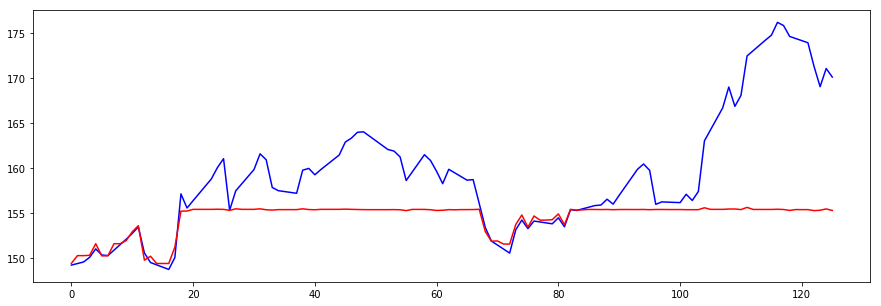

In [400]:
plt.plot(y_t, color='blue')
plt.plot(predictions, color='red')
plt.show()

/Users/manika/anaconda3/envs/stock/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [71]:
svmD = finalData

In [73]:
svmD["50d"] = np.round(svmD["Close"].rolling(window = 50, center = False).mean(), 2)
z1 = svmD['Close'][0:49]
svmD['50d'][0:49] = z1

In [74]:
svmD

,Open,High,Low,Close,Adj Close,Volume,prev_diff,sm_open,sm_high,sm_low,sm_close,sm_adj_close,sm_volume,sm_prev_diff,50d
2010-01-04,30.490000,30.642857,30.340000,30.572857,27.406532,1.234324e+08,0.000000,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09,0.000000,30.572857
2010-01-05,30.657143,30.798571,30.464285,30.625713,27.453915,1.504762e+08,0.052856,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09,3.530030,30.625713
2010-01-06,30.625713,30.747143,30.107143,30.138571,27.017223,1.380400e+08,-0.487142,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09,0.619995,30.138571
2010-01-07,30.250000,30.285715,29.864286,30.082857,26.967278,1.192828e+08,-0.055714,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09,4.549926,30.082857
2010-01-08,30.042856,30.285715,29.865715,30.282858,27.146566,1.119027e+08,0.200001,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09,3.290039,30.282858
2010-01-09,30.161904,30.333334,29.836667,30.193810,27.066742,1.131209e+08,-0.089048,1142.333334,1146.840007,1138.153321,1145.646647,1145.646647,4.344987e+09,0.666667,30.193810
2010-01-10,30.280952,30.380953,29.807620,30.104763,26.986917,1.143392e+08,-0.089048,1144.146647,1148.289998,1140.086670,1146.313313,1146.313313,4.300383e+09,0.666667,30.104763
2010-01-11,30.400000,30.428572,29.778572,30.015715,26.907093,1.155574e+08,-0.089048,1145.959961,1149.739990,1142.020020,1146.979980,1146.979980,4.255780e+09,0.666667,30.015715
2010-01-12,29.884285,29.967142,29.488571,29.674286,26.601023,1.486149e+08,-0.341429,1143.810059,1143.810059,1131.770020,1136.219971,1136.219971,4.716160e+09,-10.760009,29.674286
2010-01-13,29.695715,30.132856,29.157143,30.092857,26.976244,1.514730e+08,0.418571,1137.310059,1148.400024,1133.180054,1145.680054,1145.680054,4.170360e+09,9.460083,30.092857


In [75]:
import numpy as np

index = int(np.floor(svmD.shape[0]*0.95))
train, test = svmD[:index], svmD[index:]
print('Size of train set: ', train.shape)
print('Size of test set: ', test.shape)

Size of train set:  (2732, 15)
Size of test set:  (144, 15)


In [76]:
X_train = train.loc[:, train.columns != 'Close']
y_train = train['Close']

In [77]:
X_test = test.loc[:, test.columns != 'Close']
y_test = test['Close']
y_test.shape

(144,)

In [78]:
'''
    Running Support Vector Regression Model.
'''
from __future__ import print_function

import os
import sys
import pandas as pd
from sklearn.svm import SVR
from sklearn import cross_validation
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cross_validation import train_test_split

def convert_to_integer(dt_time):
    return 10000*dt_time.year + 1000*dt_time.month + dt_time.day

def svm(file_dataframe, test_size=0.2, cols=['date', 'open']):
#     '''
#         Run Logistic Regression
#     '''

#     print('Loading data...')

#     if 'date' in file_dataframe:
#         file_dataframe['new_col'] = pd.to_datetime(file_dataframe['date']).astype(datetime)
#         #file_dataframe['date'] = pd.to_datetime(file_dataframe['date'])
#         file_dataframe['new_col'].apply(lambda dt_time:10000*dt_time.year + 1000*dt_time.month + dt_time.day).astype(int)

#     print(file_dataframe['new_col'])

#     X = file_dataframe['open']
#     y = file_dataframe['new_col']

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    #svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_lin = SVR(kernel='linear', C=1)
    #svr_poly = SVR(kernel='poly', C=1e3, degree=2)

    #parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

    #loo = cross_validation.LeaveOneOut(len(y_train) - 1)
    #clf = grid_search.GridSearchCV(svr_rbf, parameters)
    scores = []

    #svr_rbf.fit(X_train, y_train)
    svr_lin.fit(X_train, y_train)
    #svr_poly.fit(X_train, y_train)

    #scores.append(cross_validation.cross_val_score(svr_rbf, \
    #    X_test, y_test, scoring='mean_squared_error', cv=loo).mean())
    scores.append(cross_validation.cross_val_score(svr_lin, \
        X_test, y_test, scoring='mean_squared_error', cv=loo).mean())
    #scores.append(cross_validation.cross_val_score(svr_poly, \
    #    X_test, y_test, scoring='mean_squared_error', cv=loo).mean())
    
    return scores

In [79]:
svr_lin = SVR(kernel='linear', C=1)

In [ ]:
scores = []

svr_lin.fit(X_train, y_train)

predictions = svr_lin.predict(X_test)

#svr_poly.fit(X_train, y_train)

#scores.append(cross_validation.cross_val_score(svr_rbf, \
#    X_test, y_test, scoring='mean_squared_error', cv=loo).mean())


In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(y_test, predictions)
error

In [ ]:
y_t = []
for item in y_test:
    y_t.append(item)

In [ ]:
plt.plot(y_t, color='blue')
plt.plot(predictions, color='red')
plt.show()

Enter the Company Symbol: aapl
StandardScaler(copy=True, with_mean=True, with_std=True)


/Users/manika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/manika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/manika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/manika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/manika/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for ex

Tomorrow: 
[ 170.52018117]
MSE:
2.06540692328
<class 'pandas.core.series.Series'>
(289,)
<class 'numpy.ndarray'>
(289,)


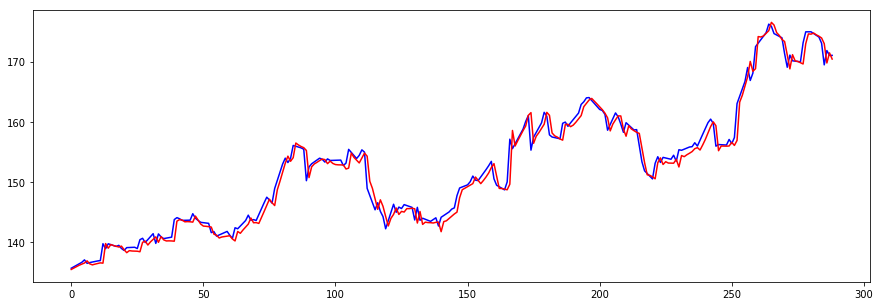

In [8]:
from preprocessing import *
from helpers_regressor import *
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

finalData = main()

#shifting the dataset,
X, y, today = reg_data_preprocessing(finalData)

#splitting the splitting the dataset
X_train, y_train, X_test, y_test = split_dataset(X, y, 0.90)

scaler = StandardScaler()
print(scaler.fit(X_train))
StandardScaler(copy=True, with_mean=True, with_std=True)
X_train_transform = scaler.transform(X_train)
X_test_transform = scaler.transform(X_test)
today_transform = scaler.transform(today.reshape(1,-1))

scaler_y = StandardScaler()
scaler_y.fit(y_train.reshape(-1,1))
y_train_transform = scaler_y.transform(y_train.reshape(-1,1))
y_test_transform = scaler_y.transform(y_test.reshape(-1,1))

svm_linear = SVR(kernel='linear', C=2500)

svm_linear.fit(X_train_transform, y_train_transform)
predictions = svm_linear.predict(X_test_transform)

prediction_today = svm_linear.predict(today_transform)
actual_today = scaler_y.inverse_transform(prediction_today)
print ("Tomorrow: ")
print (actual_today)

scaled_predictions = scaler_y.inverse_transform(predictions)
error = get_mse(y_test, scaled_predictions)
print ("MSE:")
print (error)

print (type(y_test))
print (y_test.shape)
print (type(scaled_predictions))
print (scaled_predictions.shape)

# plot
plt.plot(y_test.as_matrix(), color='blue')
plt.plot(scaled_predictions, color='red')
plt.savefig("images/svm.png")
plt.show()

In [13]:
main().tail(40)

Enter the Company Symbol: intu


,Open,High,Low,Close,Adj Close,Volume,prev_diff,50d,10d_vol,sm_open,sm_high,sm_low,sm_close,sm_adj_close,sm_volume,sm_prev_diff
2017-10-25,148.350006,149.740005,147.970001,149.460007,149.460007,1.460600e+06,0.840012,144.19,1.393675,148.350006,149.740005,147.970001,149.460007,149.460007,1.460600e+06,0.840012
2017-10-26,150.050003,151.949997,149.429993,151.330002,151.330002,1.124800e+06,1.869995,144.40,1.643825,150.050003,151.949997,149.429993,151.330002,151.330002,1.124800e+06,1.869995
2017-10-27,151.399994,153.860001,150.820007,153.460007,153.460007,1.173100e+06,2.130005,144.65,2.182249,151.399994,153.860001,150.820007,153.460007,153.460007,1.173100e+06,2.130005
2017-10-28,152.006663,153.659999,150.676671,152.790004,152.790004,1.100033e+06,-0.670003,144.87,2.290544,152.006663,153.659999,150.676671,152.790004,152.790004,1.100033e+06,-0.670003
2017-10-29,152.613332,153.459997,150.533335,152.120000,152.120000,1.026967e+06,-0.670003,145.08,2.244212,152.613332,153.459997,150.533335,152.120000,152.120000,1.026967e+06,-0.670003
2017-10-30,153.220001,153.259995,150.389999,151.449997,151.449997,9.539000e+05,-0.670003,145.26,2.197199,153.220001,153.259995,150.389999,151.449997,151.449997,9.539000e+05,-0.670003
2017-10-31,151.779999,151.990005,150.509995,151.020004,151.020004,8.589000e+05,-0.429993,145.43,2.049402,151.779999,151.990005,150.509995,151.020004,151.020004,8.589000e+05,-0.429993
2017-11-01,151.850006,152.220001,150.550003,151.360001,151.360001,8.924000e+05,0.339997,145.61,1.800428,151.850006,152.220001,150.550003,151.360001,151.360001,8.924000e+05,0.339997
2017-11-02,151.339996,152.320007,150.600006,152.149994,152.149994,9.255000e+05,0.789993,145.81,1.374637,151.339996,152.320007,150.600006,152.149994,152.149994,9.255000e+05,0.789993
2017-11-03,151.889999,154.039993,151.039993,153.639999,153.639999,9.624000e+05,1.490005,146.04,1.179251,151.889999,154.039993,151.039993,153.639999,153.639999,9.624000e+05,1.490005
